<h1>Airborne Wind Energy Course Workshop 2019</h1>

During this workshop we want you to play around with the Quasi-Steady Model (QSM). The QSM has already been implemented for you, so you don't need to worry about that yourself. We are only going to import some of the implemented functionalities, such that we can quickly start with getting a taste of the performance of a pumping Airborne Wind Energy (AWE) system. Don't let all the code scare you off. We have tried to code all the examples in an intuitive manner. To do so, we have used Python, which in general has a good readability and should not be too hard to understand if you have a basic understanding of programming.

First, let's initiate the objects that specify the wind conditions and the system. 

In [1]:
from qsm import Environment, KiteKinematics, StaticAerodynamics, SteadyState
import matplotlib.pyplot as plt
import numpy as np

# Creating uniform wind field input.
env_state = {
    'wind_speed': 7.,  # [m/s]
    'air_density': 1.225,  # [kg/m^3]
}
env_state = Environment(**env_state)

# Creating system properties input.
c_l = 1.
l_to_d = 5.
sys_props = {
    'kite_projected_area': 16.7,  # [m^2]
    'kite_mass': 20.,  # [kg]
    'tether_density': 0.,  # [kg/m^3]
    'tether_diameter': 0.,  # [m]
    'lift_to_drag': l_to_d,  # [-]
    'aerodynamic_force_coefficient': c_l * np.sqrt(1. + (1. / l_to_d) ** 2.),  # [-]
}
sys_props = StaticAerodynamics(**sys_props)
sys_props.tether_mass = 0.  # [m]

From Lloyd's theory we know that the optimal reeling factor is 1/3. In the next code block we are going to check if we can find the same optimal value using the quasi-steady model. To do so, we have to assume the position of the kite. For now lets set the tether length to 1 m, the azimuth and elevation angles to 0, and the course angle to 90 degrees (horizontal flight).

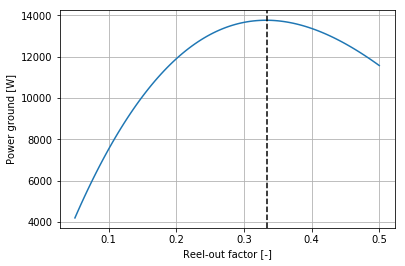

In [2]:
# Setting basic kinematic properties.
kite_position = {
    'straight_tether_length': 1.,  # [m]
    'azimuth_angle': 0.,  # [rad]
    'elevation_angle': 0.,  # [rad]
    'course_angle': 90.*np.pi/180.,  # [rad]
}
kite_position = KiteKinematics(**kite_position)

n_reeling_factors = 100
reel_out_factors = np.linspace(0.05, 0.5, n_reeling_factors)
power = np.zeros(n_reeling_factors)
for i, rf in enumerate(reel_out_factors):
    ss = SteadyState()
    ss.control_settings = ('reeling_factor', rf)
    ss.find_state(sys_props, env_state, kite_position)
    power[i] = ss.power_ground
        
plt.plot(reel_out_factors, power)
plt.axvline(1/3., linestyle='--', color='k')
plt.xlabel('Reel-out factor [-]')
plt.ylabel('Power ground [W]')
plt.grid()

So indeed, from the upper plot we can observe that the power is maximum for a reeling factor of 1/3. How does this change when we change the position of the kite? Play around with the position of the kite in the previous code block and see how the curve changes. We have only determined the instaneous performance for a single point during reel-out. However, for pumping AWE systems, we need to reel the kite back in as well. Do you think this will affect the optimal reel-out factor? Lets initiate two kite positions; one that represents the reel-out phase and one that represents the reel-in phase.

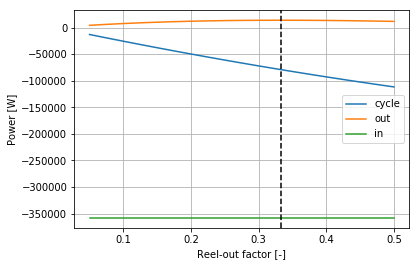

In [3]:
# Setting basic kinematic properties.
kite_position_out = {
    'straight_tether_length': 1.,  # [m]
    'azimuth_angle': 0.,  # [rad]
    'elevation_angle': 0.,  # [rad]
    'course_angle': 90.*np.pi/180.,  # [rad]
}
kite_position_out = KiteKinematics(**kite_position_out)

kite_position_in = {
    'straight_tether_length': 1.,  # [m]
    'azimuth_angle': 0.,  # [rad]
    'elevation_angle': 0.,  # [rad]
    'course_angle': 180.*np.pi/180.,  # [rad]
}
kite_position_in = KiteKinematics(**kite_position_in)

def calc_mean_cycle_power(rf_out, rf_in):
    ss_out = SteadyState()
    ss_out.control_settings = ('reeling_factor', rf_out)
    ss_out.find_state(sys_props, env_state, kite_position_out)
    p_out = ss_out.power_ground
    v_out = ss_out.reeling_speed

    ss_in = SteadyState()
    ss_in.control_settings = ('reeling_factor', rf_in)
    ss_in.find_state(sys_props, env_state, kite_position_in)
    p_in = ss_in.power_ground
    v_in = -ss_in.reeling_speed

    mean_cycle_power = (p_out/v_out + p_in/v_in) * v_out*v_in/(v_out + v_in)
    
    return mean_cycle_power, p_out, p_in

n_reeling_factors = 100
reel_out_factors = np.linspace(0.05, 0.5, n_reeling_factors)
reel_in_factor = -1

mean_cycle_power = np.zeros(n_reeling_factors)
power_out = np.zeros(n_reeling_factors)
power_in = np.zeros(n_reeling_factors)
for i, rf_out in enumerate(reel_out_factors):
    mcp, p_out, p_in = calc_mean_cycle_power(rf_out, reel_in_factor)
    mean_cycle_power[i] = mcp
    power_out[i] = p_out
    power_in[i] = p_in

plt.plot(reel_out_factors, mean_cycle_power, label="cycle")
plt.plot(reel_out_factors, power_out, label="out")
plt.plot(reel_out_factors, power_in, label="in")

plt.axvline(1/3., linestyle='--', color='k')
plt.xlabel('Reel-out factor [-]')
plt.ylabel('Power [W]')
plt.legend()
plt.grid()

It turns out that the mean cycle power negative and monotonically decreasing. This implies that we are consuming energy regardless of the choice for the reel-out factor. Do you know what could be the cause of this? Generally the kite is depowered during the rectraction phase: the aerodynamics properties of the kite are changed such that less energy needs to be put into the system to lower the kite. Lets try again to identify the optimal reel-out factor, however, this time we differentiate between the aerodynamic properties during reel-out and reel-in.

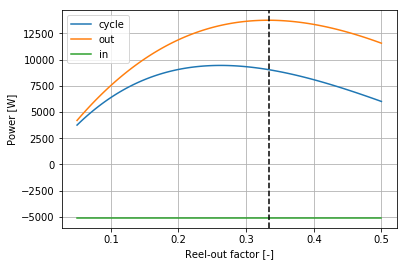

In [4]:
from copy import copy

sys_props_out = copy(sys_props)
sys_props_in = copy(sys_props)
c_l = .2
l_to_d = 1.
sys_props_in.lift_to_drag = l_to_d
sys_props_in.aerodynamic_force_coefficient = c_l * np.sqrt(1. + (1. / l_to_d) ** 2.)

def calc_mean_cycle_power(rf_out, rf_in):
    ss_out = SteadyState()
    ss_out.control_settings = ('reeling_factor', rf_out)
    ss_out.find_state(sys_props_out, env_state, kite_position_out)
    p_out = ss_out.power_ground
    v_out = ss_out.reeling_speed

    ss_in = SteadyState()
    ss_in.control_settings = ('reeling_factor', rf_in)
    ss_in.find_state(sys_props_in, env_state, kite_position_in)
    p_in = ss_in.power_ground
    v_in = -ss_in.reeling_speed

    mean_cycle_power = (p_out/v_out + p_in/v_in) * v_out*v_in/(v_out + v_in)
    
    return mean_cycle_power, p_out, p_in

n_reeling_factors = 100
reel_out_factors = np.linspace(0.05, 0.5, n_reeling_factors)
reel_in_factor = -1

mean_cycle_power = np.zeros(n_reeling_factors)
power_out = np.zeros(n_reeling_factors)
power_in = np.zeros(n_reeling_factors)
for i, rf_out in enumerate(reel_out_factors):
    mcp, p_out, p_in = calc_mean_cycle_power(rf_out, reel_in_factor)
    mean_cycle_power[i] = mcp
    power_out[i] = p_out
    power_in[i] = p_in

plt.plot(reel_out_factors, mean_cycle_power, label="cycle")
plt.plot(reel_out_factors, power_out, label="out")
plt.plot(reel_out_factors, power_in, label="in")

plt.axvline(1/3., linestyle='--', color='k')
plt.xlabel('Reel-out factor [-]')
plt.ylabel('Power [W]')
plt.legend()
plt.grid()

Nice! We were able to reduce the reel-in power substantially. Now we are actually producing energy over the full range of reel-out factors. The mean cycle power curve shows a maximum at a different reel-out factor than the reel-out power curve. Is it beneficial to reel-out slower or faster compared to the optimal condition that follows from Lloyd's theory? In the previous code block, change the reel-in factor. How does this change the optimal reel-out factor? Note that the optimal reel-out factor is also dependent on the reel-in factor. Lets try to find the combination of reel-out and reel-in factor that maximises the mean cycle power using SciPy's minimize function.

In [5]:
from scipy import optimize as op

def obj_fun(x):
    mcp = calc_mean_cycle_power(x[0], x[1])[0]
    return -mcp

starting_point = (1/3., -1)
bounds = ((0., 1.), (-2., -.5))
res = op.minimize(obj_fun, starting_point, bounds=bounds, method='SLSQP')
x_opt = res['x']
print(res)

     fun: -9458.307512610905
     jac: array([0.03076172, 0.01318359])
 message: 'Optimization terminated successfully.'
    nfev: 29
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([ 0.26238089, -1.07142904])


Let's verify if the reel-out and reel-in factor combination found by the optimization indeed corresponds to a maximum of the mean cycle power. Is the mean cycle power more sensitive to the reel-out or reel-in factor?

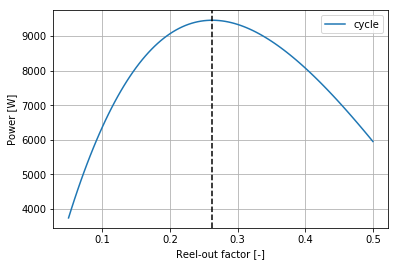

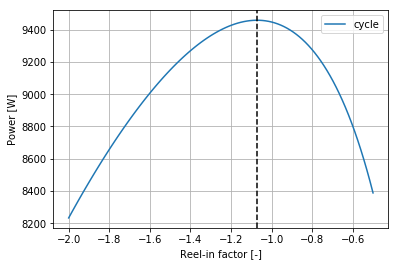

In [6]:
rf_out_opt = x_opt[0]
rf_in_opt = x_opt[1]

n_reeling_factors = 100
reel_out_factors = np.linspace(0.05, 0.5, n_reeling_factors)
mean_cycle_power = np.zeros(n_reeling_factors)
for i, rf_out in enumerate(reel_out_factors):
    mean_cycle_power[i] = calc_mean_cycle_power(rf_out, rf_in_opt)[0]

plt.plot(reel_out_factors, mean_cycle_power, label="cycle")
plt.axvline(rf_out_opt, linestyle='--', color='k')
plt.xlabel('Reel-out factor [-]')
plt.ylabel('Power [W]')
plt.legend()
plt.grid()

plt.figure()
reel_in_factors = np.linspace(-2., -0.5, n_reeling_factors)
mean_cycle_power = np.zeros(n_reeling_factors)
for i, rf_in in enumerate(reel_in_factors):
    mean_cycle_power[i] = calc_mean_cycle_power(rf_out_opt, rf_in)[0]

plt.plot(reel_in_factors, mean_cycle_power, label="cycle")
plt.axvline(rf_in_opt, linestyle='--', color='k')
plt.xlabel('Reel-in factor [-]')
plt.ylabel('Power [W]')
plt.legend()
plt.grid()

So far we have only assessed the system's performance for a single wind speed. However, as you probably know, the performance is highly dependent on the wind speed. The power in the wind is a function of the wind speed cubed. Do you think that the power we can harness using an AWE system is also a function of the wind speed cubed?

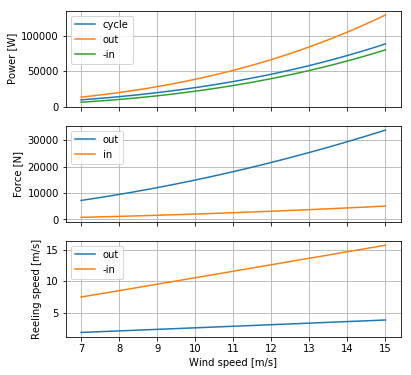

In [7]:
def calc_mean_cycle_power_phase0(rf_out, rf_in, v_wind):
    env_state.set_reference_wind_speed(v_wind)
    
    ss_out = SteadyState()
    ss_out.control_settings = ('reeling_factor', rf_out)
    ss_out.find_state(sys_props_out, env_state, kite_position_out)
    p_out = ss_out.power_ground 
    v_out = ss_out.reeling_speed

    ss_in = SteadyState()
    ss_in.control_settings = ('reeling_factor', rf_in)
    ss_in.find_state(sys_props_in, env_state, kite_position_in)
    p_in = ss_in.power_ground
    v_in = -ss_in.reeling_speed

    mean_cycle_power = (p_out/v_out + p_in/v_in) * v_out*v_in/(v_out + v_in)
    
    result = {
        'mean_cycle_power': mean_cycle_power,
        'power_reel_out': p_out,
        'tether_force_out': ss_out.tether_force_ground,
        'speed_reel_out': v_out,
        'power_reel_in': p_in,
        'tether_force_in': ss_in.tether_force_ground,
        'speed_reel_in': v_in,
    }
    return result

def obj_fun_phase0(x, v_wind):
    mcp = calc_mean_cycle_power_phase0(x[0], x[1], v_wind)['mean_cycle_power']
    return -mcp

starting_point = (1/3., -1)
n_wind_speeds = 30
winds_speeds = np.linspace(7, 15, n_wind_speeds)
mean_cycle_power = np.zeros(n_wind_speeds)
power_out, force_out, speed_out = np.zeros(n_wind_speeds), np.zeros(n_wind_speeds), np.zeros(n_wind_speeds)
power_in, force_in, speed_in = np.zeros(n_wind_speeds), np.zeros(n_wind_speeds), np.zeros(n_wind_speeds)

for i, v_wind in enumerate(winds_speeds):
    bounds = ((.1, 1.), (-2., -.5))
    res = op.minimize(obj_fun_phase0, starting_point, bounds=bounds, method='SLSQP', args=(v_wind,))
    performance_dict = calc_mean_cycle_power_phase0(res['x'][0], res['x'][1], v_wind)
    
    mean_cycle_power[i] = performance_dict['mean_cycle_power']
    power_out[i] = performance_dict['power_reel_out']
    force_out[i] = performance_dict['tether_force_out']
    speed_out[i] = performance_dict['speed_reel_out']
    power_in[i] = performance_dict['power_reel_in']
    force_in[i] = performance_dict['tether_force_in']
    speed_in[i] = performance_dict['speed_reel_in']
    starting_point = res['x']

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(6.0, 6.0))    
ax[0].plot(winds_speeds, mean_cycle_power, label="cycle")
ax[0].plot(winds_speeds, power_out, label="out")
ax[0].plot(winds_speeds, -power_in, label="-in")
ax[0].legend()
ax[1].plot(winds_speeds, force_out, label="out")
ax[1].plot(winds_speeds, force_in, label="in")
ax[1].legend()
ax[2].plot(winds_speeds, speed_out, label="out")
ax[2].plot(winds_speeds, speed_in, label="-in")
ax[2].legend()

ax[0].set_ylabel('Power [W]')
ax[1].set_ylabel('Force [N]')
ax[2].set_ylabel('Reeling speed [m/s]')
ax[2].set_xlabel('Wind speed [m/s]')

for a in ax: a.grid()
    
# z = np.polyfit(winds_speeds[10:20:3], mean_cycle_power[10:20:3], 3)
# p = np.polyval(z, winds_speeds)
# ax[0].plot(winds_speeds, p, '--', label="cubic")

Is the power curve that we obtained realistic? What happens if we evaluate the power for even higher wind speeds? Try it out by changing the maximum value for the 'winds_speeds' array. Probably the curve is not really representative for an actual system: we need to consider some system limits, such as maximum force that the tether can hold and maximum power for which the generator is designed.

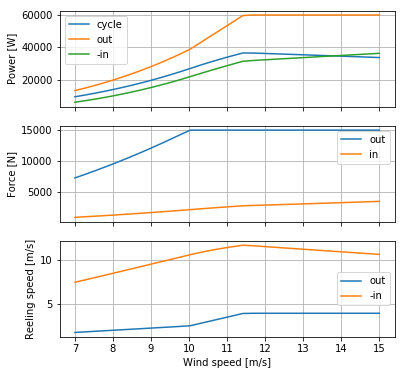

In [8]:
def calc_mean_cycle_power_phase0(rf_out, rf_in, v_wind):
    env_state.set_reference_wind_speed(v_wind)
    
    ss_out = SteadyState()
    ss_out.control_settings = ('reeling_factor', rf_out)
    ss_out.find_state(sys_props_out, env_state, kite_position_out)
    p_out = ss_out.power_ground 
    v_out = ss_out.reeling_speed

    ss_in = SteadyState()
    ss_in.control_settings = ('reeling_factor', rf_in)
    ss_in.find_state(sys_props_in, env_state, kite_position_in)
    p_in = ss_in.power_ground
    v_in = -ss_in.reeling_speed

    mean_cycle_power = (p_out/v_out + p_in/v_in) * v_out*v_in/(v_out + v_in)
    
    result = {
        'mean_cycle_power': mean_cycle_power,
        'power_reel_out': p_out,
        'tether_force_out': ss_out.tether_force_ground,
        'speed_reel_out': v_out,
        'power_reel_in': p_in,
        'tether_force_in': ss_in.tether_force_ground,
        'speed_reel_in': v_in,
    }
    return result

def obj_fun_phase0(x, v_wind):
    mcp = calc_mean_cycle_power_phase0(x[0], x[1], v_wind)['mean_cycle_power']
    return -mcp

tether_force_limit = 15000

def calc_mean_cycle_power_phase1(rf_in, v_wind):
    env_state.set_reference_wind_speed(v_wind)
    
    ss_out = SteadyState()
    ss_out.control_settings = ('tether_force_ground', tether_force_limit)
    ss_out.find_state(sys_props_out, env_state, kite_position_out)
    p_out = ss_out.power_ground
    v_out = ss_out.reeling_speed

    ss_in = SteadyState()
    ss_in.control_settings = ('reeling_factor', rf_in)
    ss_in.find_state(sys_props_in, env_state, kite_position_in)
    p_in = ss_in.power_ground
    v_in = -ss_in.reeling_speed

    mean_cycle_power = (p_out/v_out + p_in/v_in) * v_out*v_in/(v_out + v_in)
    
    result = {
        'mean_cycle_power': mean_cycle_power,
        'power_reel_out': p_out,
        'tether_force_out': tether_force_limit,
        'speed_reel_out': v_out,
        'power_reel_in': p_in,
        'tether_force_in': ss_in.tether_force_ground,
        'speed_reel_in': v_in,
    }
    return result

def obj_fun_phase1(x, v_wind):
    mcp = calc_mean_cycle_power_phase1(x[0], v_wind)['mean_cycle_power']
    return -mcp

power_limit = 60000

def calc_mean_cycle_power_phase2(rf_in, v_wind):
    env_state.set_reference_wind_speed(v_wind)
    
    p_out = power_limit
    f_out = tether_force_limit
    v_out = p_out/f_out

    ss_in = SteadyState()
    ss_in.control_settings = ('reeling_factor', rf_in)
    ss_in.find_state(sys_props_in, env_state, kite_position_in)
    p_in = ss_in.power_ground
    f_in = ss_in.tether_force_ground
    v_in = -ss_in.reeling_speed

    mean_cycle_power = (p_out/v_out + p_in/v_in) * v_out*v_in/(v_out + v_in)
    
    result = {
        'mean_cycle_power': mean_cycle_power,
        'power_reel_out': p_out,
        'tether_force_out': f_out,
        'speed_reel_out': v_out,
        'power_reel_in': p_in,
        'tether_force_in': ss_in.tether_force_ground,
        'speed_reel_in': v_in,
    }
    return result

def obj_fun_phase2(x, v_wind):
    mcp = calc_mean_cycle_power_phase2(x[0], v_wind)['mean_cycle_power']
    return -mcp
    
starting_point = (1/3., -1)
n_wind_speeds = 30
winds_speeds = np.linspace(7, 15, n_wind_speeds)
mean_cycle_power = np.zeros(n_wind_speeds)
power_out, force_out, speed_out = np.zeros(n_wind_speeds), np.zeros(n_wind_speeds), np.zeros(n_wind_speeds)
power_in, force_in, speed_in = np.zeros(n_wind_speeds), np.zeros(n_wind_speeds), np.zeros(n_wind_speeds)
phase = 0
for i, v_wind in enumerate(winds_speeds):
    if phase == 0:
        bounds = ((.1, 1.), (-2., -.5))
        res = op.minimize(obj_fun_phase0, starting_point, bounds=bounds, method='SLSQP', args=(v_wind,))
        performance_dict = calc_mean_cycle_power_phase0(res['x'][0], res['x'][1], v_wind)
        if performance_dict['tether_force_out'] > tether_force_limit:
            phase = 1
            starting_point = (res['x'][1],)
    if phase == 1:
        bounds = ((-2., -.5),)
        res = op.minimize(obj_fun_phase1, starting_point, bounds=bounds, method='SLSQP', args=(v_wind,))
        performance_dict = calc_mean_cycle_power_phase1(res['x'][0], v_wind)
        if performance_dict['power_reel_out'] > power_limit:
            phase = 2
            starting_point = (res['x'][0],)
    if phase == 2:
        res = op.minimize(obj_fun_phase2, starting_point, bounds=bounds, method='SLSQP', args=(v_wind,))
        performance_dict = calc_mean_cycle_power_phase2(res['x'][0], v_wind)
    
    mean_cycle_power[i] = performance_dict['mean_cycle_power']
    power_out[i] = performance_dict['power_reel_out']
    force_out[i] = performance_dict['tether_force_out']
    speed_out[i] = performance_dict['speed_reel_out']
    power_in[i] = performance_dict['power_reel_in']
    force_in[i] = performance_dict['tether_force_in']
    speed_in[i] = performance_dict['speed_reel_in']
    starting_point = res['x']

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(6.0, 6.0))    
ax[0].plot(winds_speeds, mean_cycle_power, label="cycle")
ax[0].plot(winds_speeds, power_out, label="out")
ax[0].plot(winds_speeds, -power_in, label="-in")
ax[0].legend()
ax[1].plot(winds_speeds, force_out, label="out")
ax[1].plot(winds_speeds, force_in, label="in")
ax[1].legend()
ax[2].plot(winds_speeds, speed_out, label="out")
ax[2].plot(winds_speeds, speed_in, label="-in")
ax[2].legend()

ax[0].set_ylabel('Power [W]')
ax[1].set_ylabel('Force [N]')
ax[2].set_ylabel('Reeling speed [m/s]')
ax[2].set_xlabel('Wind speed [m/s]')

for a in ax: a.grid()

In [9]:
import sys
print(sys.version)

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
